In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate,accuracy

In [3]:
PATH=Path('data/')

In [4]:
src_size=array([150,210]);src_size

array([150, 210])

In [44]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [45]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train.csv',valid_pct=0.2,test='test_resized',
                             ds_tfms=tfms,size=src_size//2,bs=64).normalize(imagenet_stats)

In [46]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
2,3,2,4,1
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
5,1,5,3,1
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

In [56]:
learn=cnn_learner(data,models.resnet50,metrics=error_rate)

In [48]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


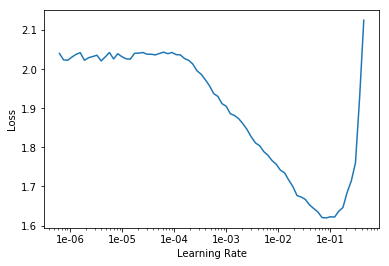

In [49]:
learn.recorder.plot()

In [50]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

epoch,train_loss,valid_loss,error_rate,time
0,1.290483,0.938273,0.360800,00:04
1,1.047596,0.803622,0.324000,00:05
2,0.861999,0.666924,0.276800,00:05
3,0.750684,0.633006,0.251200,00:04
4,0.670973,0.507516,0.212000,00:04
5,0.584559,0.474339,0.198400,00:05
6,0.519483,0.443497,0.179200,00:04
7,0.491055,0.448256,0.173600,00:04
8,0.434877,0.429395,0.159200,00:05
9,0.412069,0.400518,0.151200,00:05


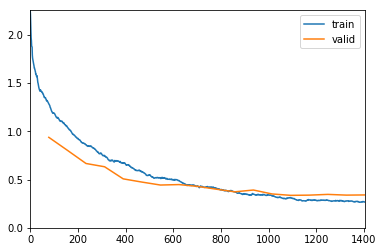

In [57]:
learn.fit_one_cycle(18,slice(1e-2),callbacks=ShowGraph(learn))

In [58]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


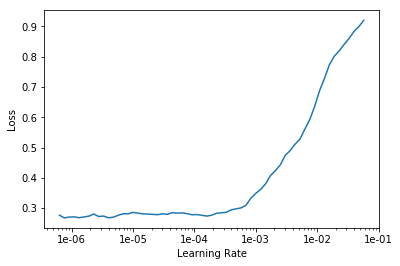

In [59]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.270724,0.339601,0.130400,00:06
1,0.275415,0.333573,0.123200,00:06
2,0.266520,0.315274,0.108000,00:06
3,0.250546,0.323018,0.120800,00:06
4,0.210506,0.333809,0.118400,00:06
5,0.163785,0.310099,0.108000,00:05
6,0.163196,0.322547,0.105600,00:06
7,0.156248,0.312709,0.108000,00:06


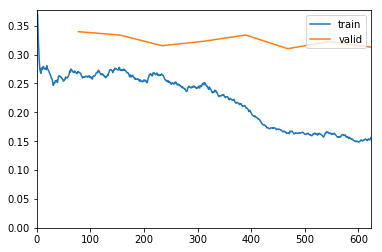

In [60]:
lr=1e-5
learn.fit_one_cycle(8,slice(lr,2e-4),callbacks=ShowGraph(learn))

In [62]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train.csv',valid_pct=0.2,test='test_resized',
                             ds_tfms=tfms,size=src_size,bs=64).normalize(imagenet_stats)

In [63]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


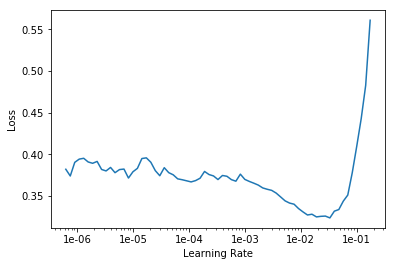

In [64]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.350199,0.238876,0.083200,00:10
1,0.298459,0.196365,0.066400,00:10
2,0.257827,0.168431,0.064000,00:10
3,0.225368,0.163423,0.055200,00:10
4,0.198722,0.153759,0.051200,00:10
5,0.180452,0.155685,0.056000,00:11
6,0.159593,0.150713,0.054400,00:10
7,0.140226,0.141892,0.050400,00:10
8,0.132001,0.164947,0.061600,00:10
9,0.125027,0.144202,0.052000,00:10


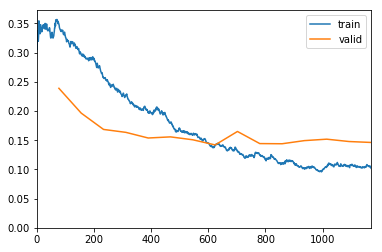

In [65]:
lr=3e-3
learn.fit_one_cycle(15,slice(lr),callbacks=ShowGraph(learn))

In [66]:
learn.save('Fresh_resnet50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


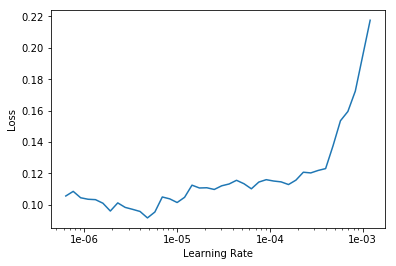

In [67]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.112139,0.145774,0.052000,00:13
1,0.102788,0.147966,0.053600,00:13
2,0.093110,0.141537,0.051200,00:13
3,0.098078,0.141057,0.048800,00:13
4,0.083716,0.145472,0.051200,00:13
5,0.083413,0.141219,0.048000,00:13
6,0.076811,0.140169,0.047200,00:13
7,0.072798,0.137613,0.047200,00:13


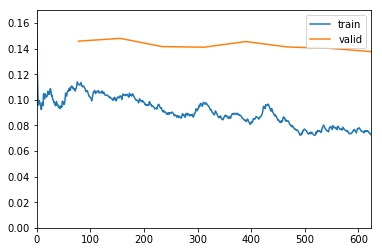

In [68]:
lr=5e-6
learn.fit_one_cycle(8,slice(lr,5e-6),callbacks=ShowGraph(learn))

In [69]:
intept=ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

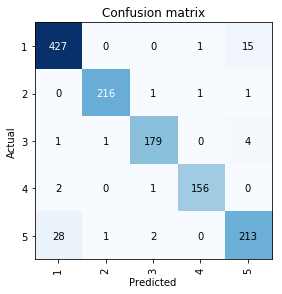

In [70]:
intept.plot_confusion_matrix()

In [71]:
intept.most_confused()

[(5, 1, 28),
 (1, 5, 15),
 (3, 5, 4),
 (4, 1, 2),
 (5, 3, 2),
 (1, 4, 1),
 (2, 3, 1),
 (2, 4, 1),
 (2, 5, 1),
 (3, 1, 1),
 (3, 2, 1),
 (4, 3, 1),
 (5, 2, 1)]

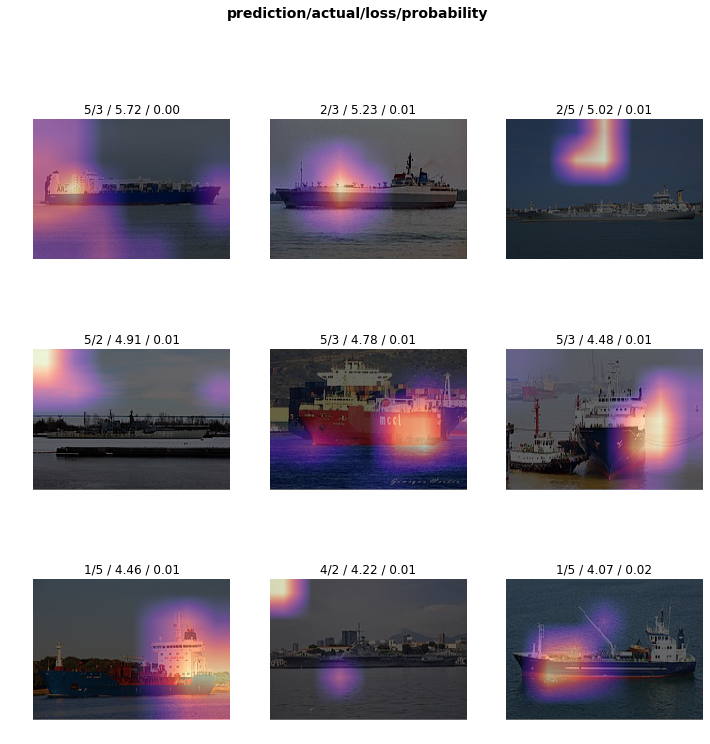

In [72]:
intept.plot_top_losses(9,heatmap=True)

In [73]:
learn.save('Fresh-resnet50-2')

In [76]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_resnet50-fresh.csv',index=False)

In [77]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train.csv',valid_pct=0,test='test_resized',
                             ds_tfms=tfms,size=src_size,bs=64).normalize(imagenet_stats)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


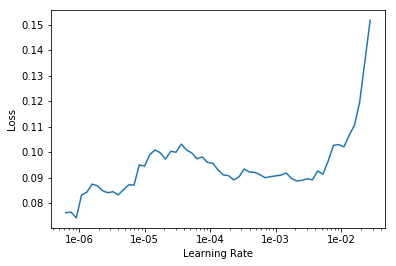

In [79]:
learn.data=data
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(8,slice(1e-7))

In [81]:
learn.save('Fresh-resnet50-3-noval')

In [82]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_resnet50-fresh-noval.csv',index=False)